# Telco Churn Analysis

## Overview

On the Alpha Consulting team, we have been tasked with investigating customer churn at Telco. 

In this report we will showcase some of the key findings from our analysis. We will also provide a high-level overview of the data, and discuss some of the key factors that are driving churn.

At the end of the report we will provide some recommendations for how we can move forward as a business to help identify customers who are at risk of churning, and to help reduce churn rates.

::: {.content-hidden}
### Import necessary libraries & load data
:::

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
file = Path("__file__").parent / "telco-customer-churn.csv"
df = pd.read_csv(file)

plt.style.use('seaborn-v0_8-talk')

## Initial Data Exploration

In [3]:
#| output: False
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
#| fig-cap: Data Sample
#| column: page
from itables import show

show(df.head(50))

### High-level overview of the data

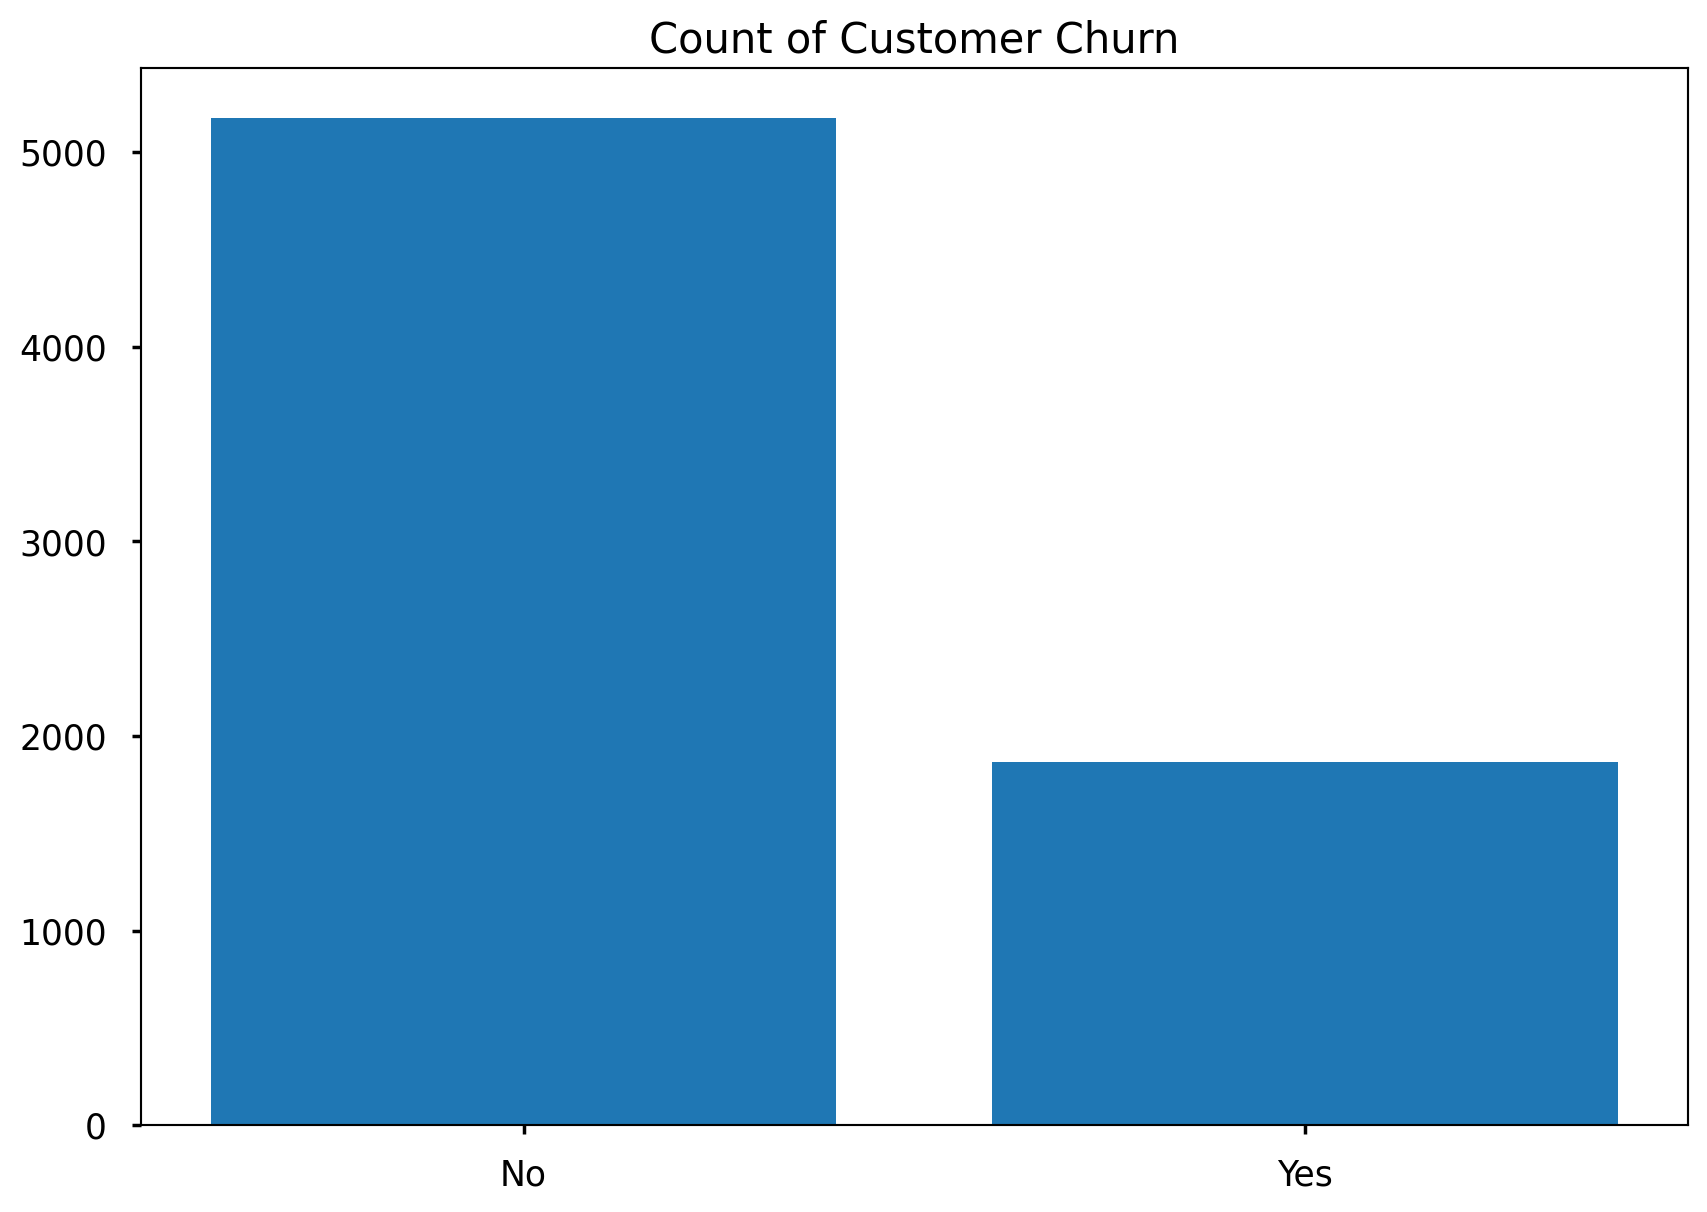

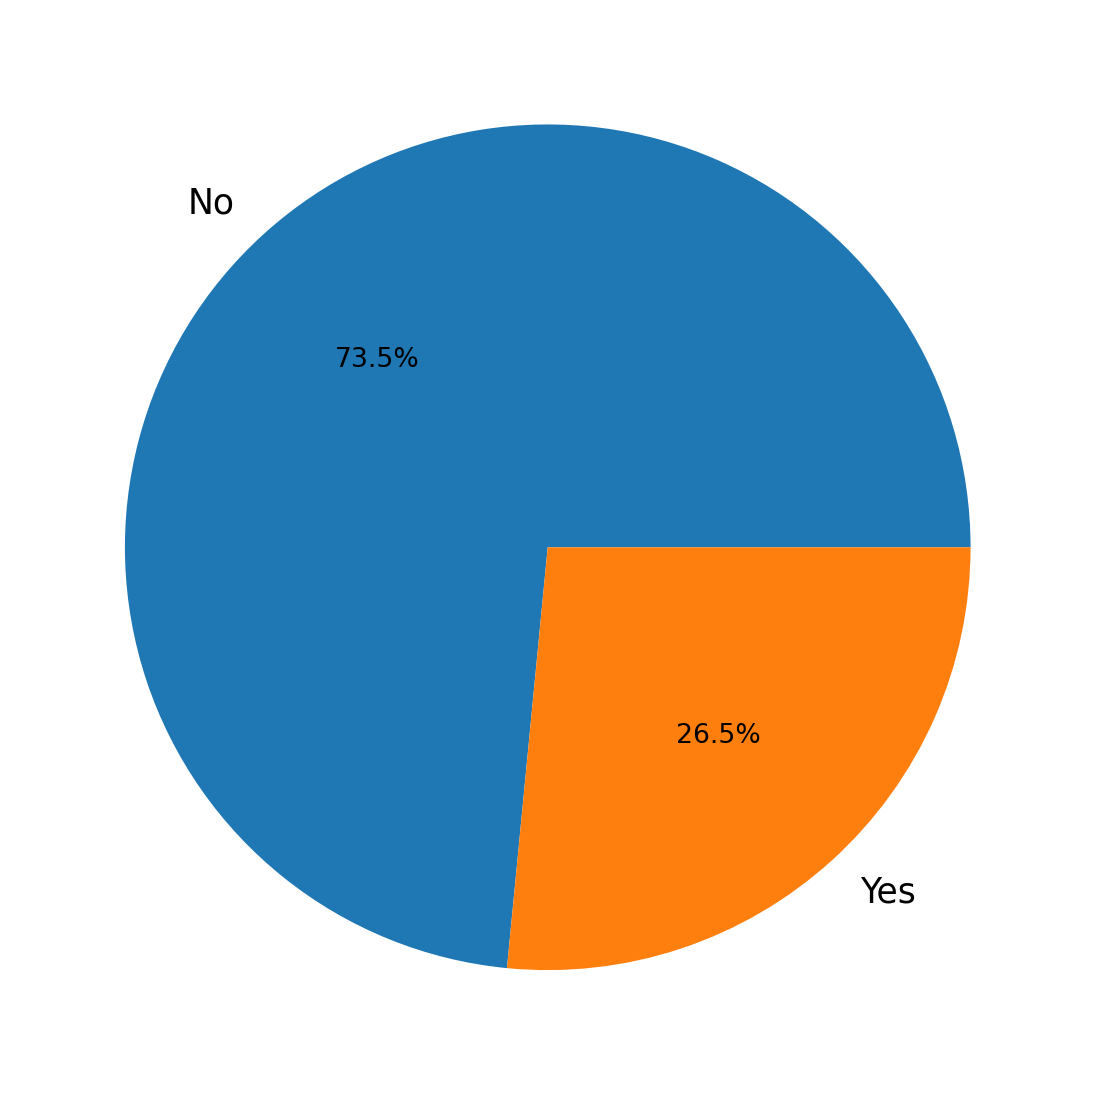

In [5]:
#| fig-width: "100px"
#| layout-ncol: 2
#| column: page
churn = df['Churn'].value_counts()
plt.title('Count of Customer Churn')
plt.bar(churn.index, churn.values)
plt.show()

pct_churn = df['Churn'].value_counts(normalize=True)
plt.pie(pct_churn, labels=pct_churn.index, autopct='%1.1f%%')
plt.show()

## Understanding the Variables that causes churn

### Numeric Features

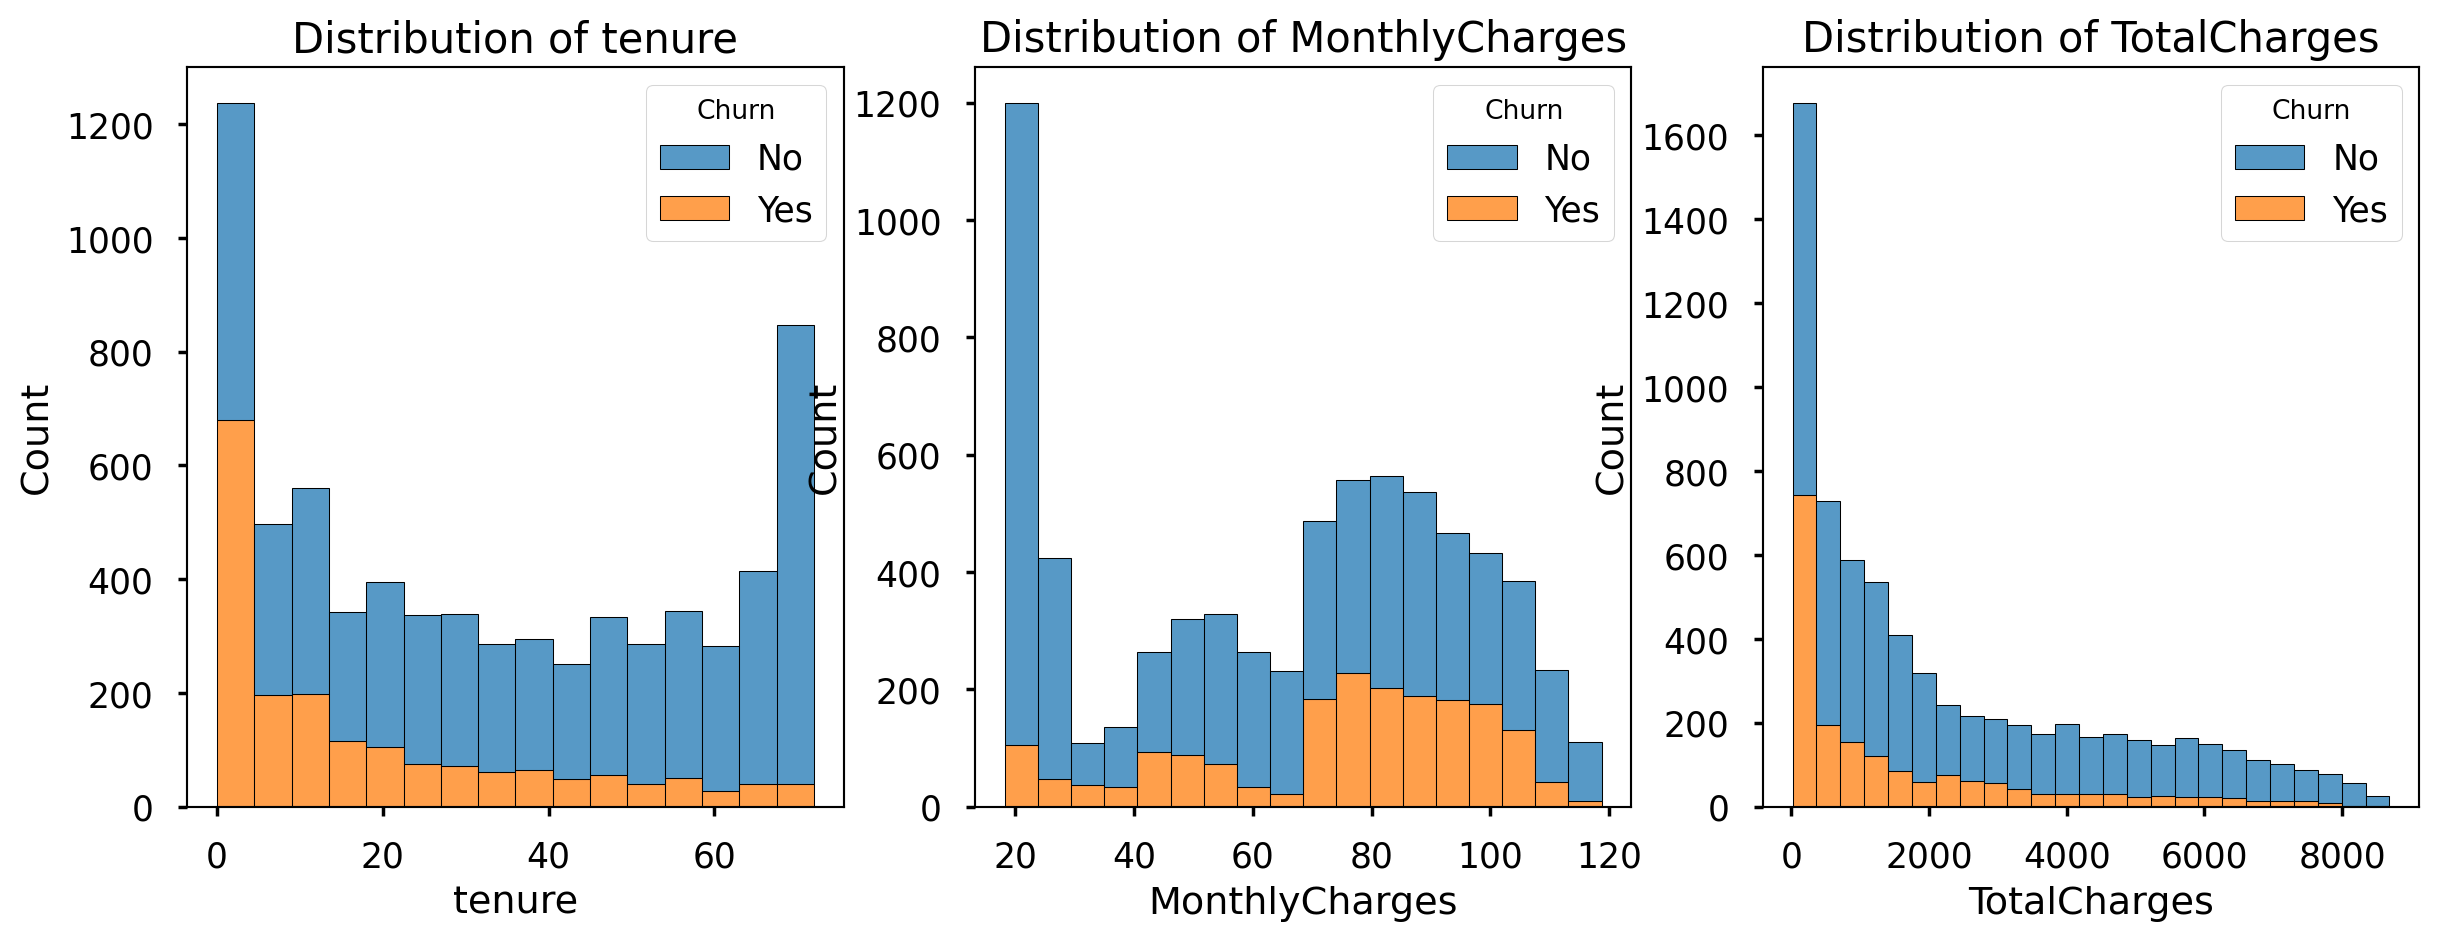

In [6]:
#| column: body-outset-left
#| out-width: 100%
#| fig-align: center
#| width: 100%
#| fig-caption: Distribution of numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 
for i, feature in enumerate(numerical_features):
    if feature == 'TotalCharges':
        df[feature] = pd.to_numeric(df[feature], errors='coerce')  # Convert to numeric
    sns.histplot(data=df, x=feature, hue='Churn', multiple="stack", ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

As you can see here there are some churned customers with high tenure, high monthly charges and high total charges. This is interesting because we would expect that customers with high tenure, low monthly charges and low total charges would be less likely to churn.

***

### Categorical Features

:::: {layout="[60, -1, 39]"} 
::: {#first-column}

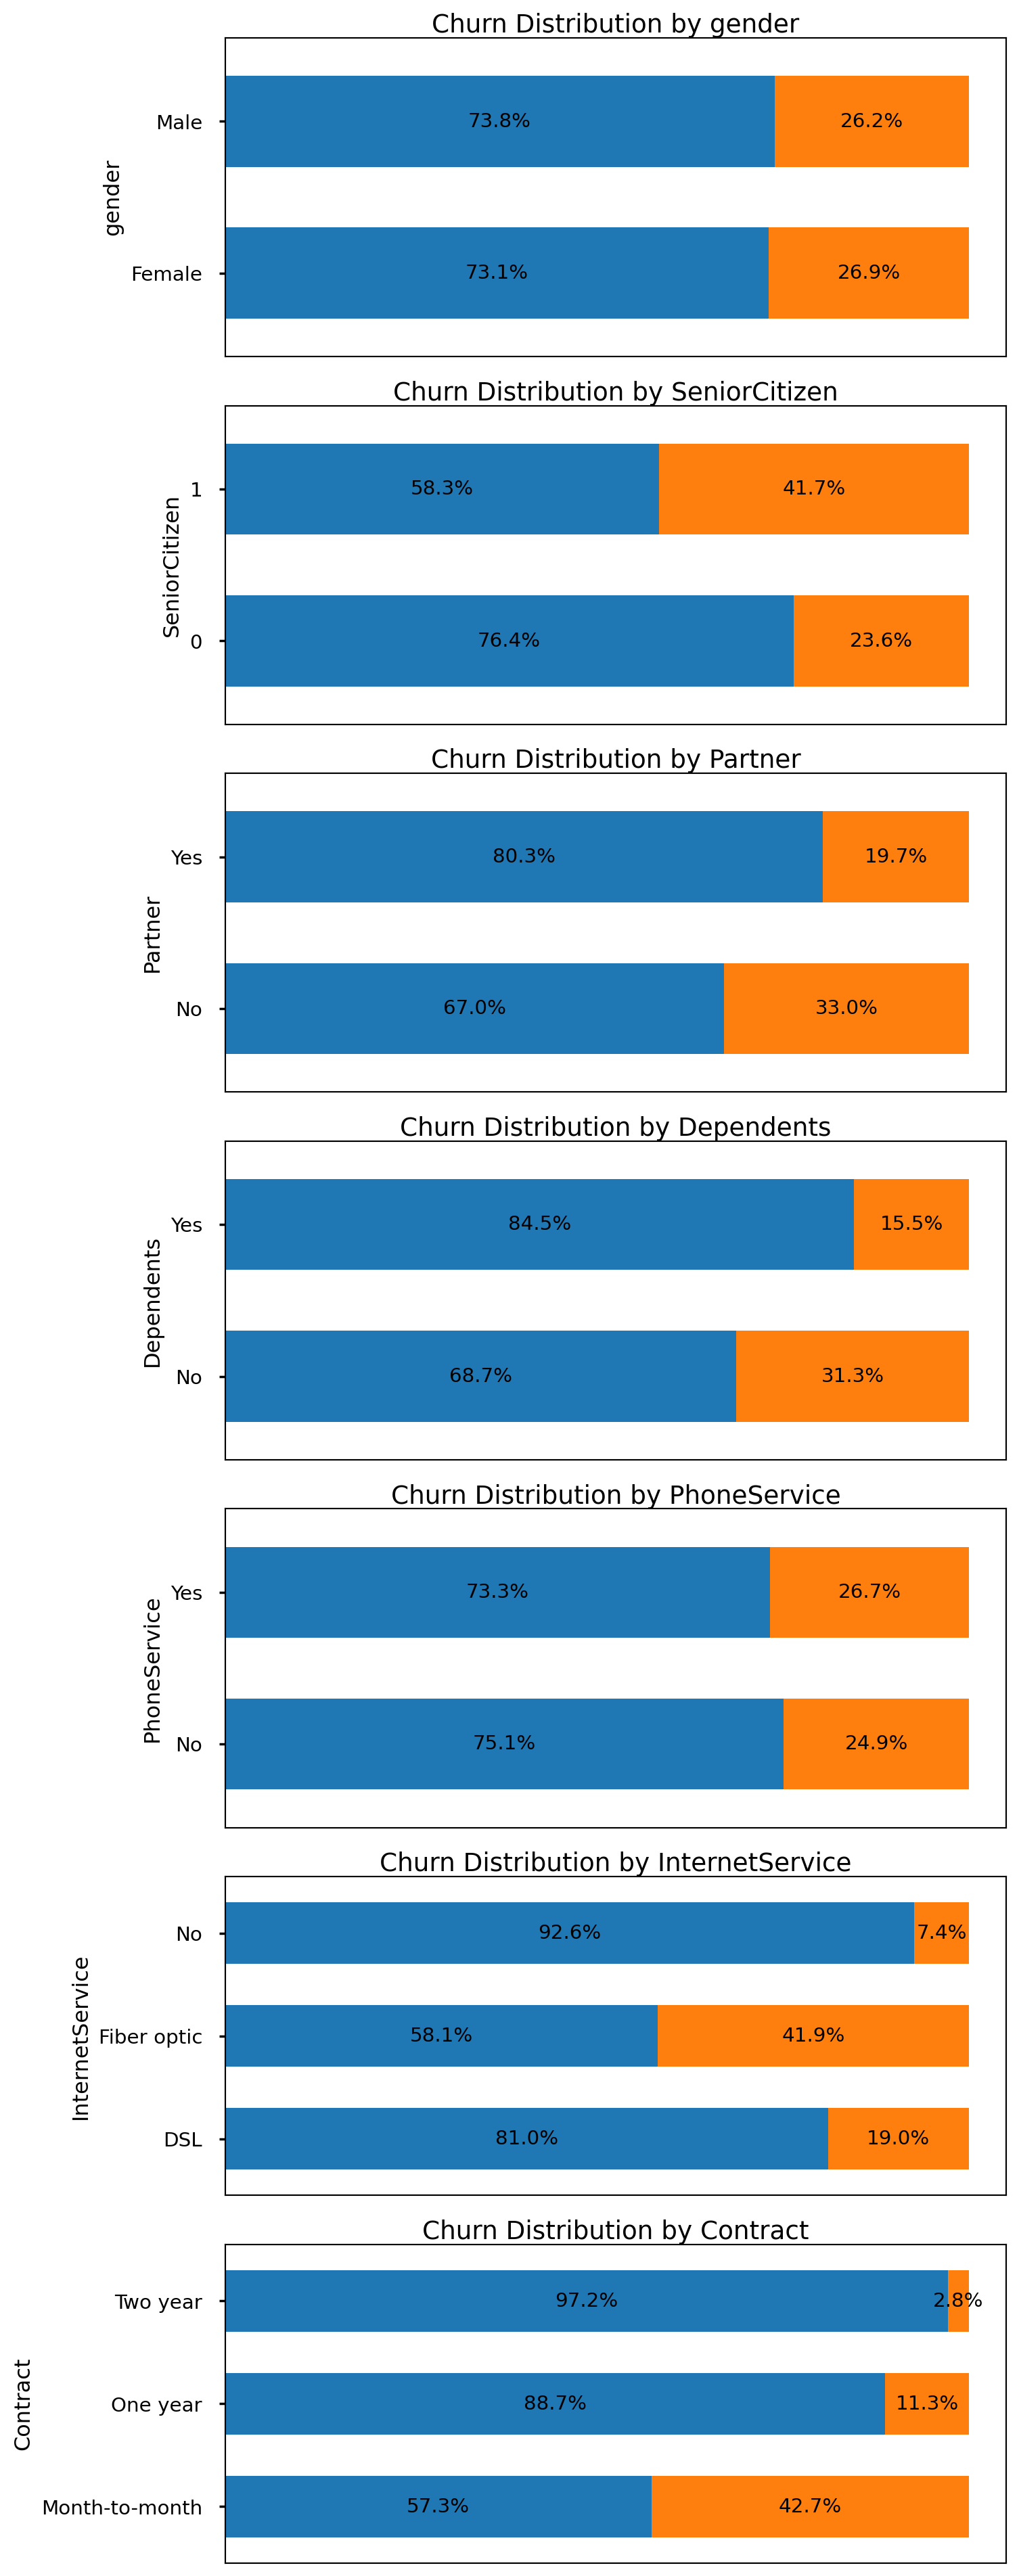

In [7]:
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 'Contract']
fig, axes = plt.subplots(7, 1, figsize=(8, 20))
axes = axes.flatten()

plt.rcParams.update({'font.size': 12})  # Increase base font size

for i, feature in enumerate(categorical_features):
    # Calculate percentages
    percentages = (df.groupby(feature)['Churn']
                    .value_counts(normalize=True)
                    .unstack()
                    .mul(100))
    
    # Create horizontal stacked bars
    percentages.plot(kind='barh', 
                    stacked=True,
                    ax=axes[i],
                    legend=False,
                    width=0.6)  # Changed from height to width
    
    # Customize the plot
    axes[i].set_title(f'Churn Distribution by {feature}', fontsize=14, pad=-30)
    axes[i].set_ylabel(feature, fontsize=12)
    
    # Add percentage labels on the bars
    for c in axes[i].containers:
        axes[i].bar_label(c, fmt='%.1f%%', label_type='center', fontsize=11)
    
    # Remove x-axis percentage labels
    axes[i].set_xticks([])
    
    # Add border around the subplot
    for spine in axes[i].spines.values():
        spine.set_visible(True)
    
    # Make tick labels larger
    axes[i].tick_params(axis='both', which='major', labelsize=11)
    
    # Adjust plot to reduce white space
    axes[i].margins(y=0.15)  # Reduce vertical margins

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

:::

::: {#second-column}
In this graph we see a few different things
- Thing 1
- Thing 2
- Thing 3

:::
::::

### Some more detailed analysis

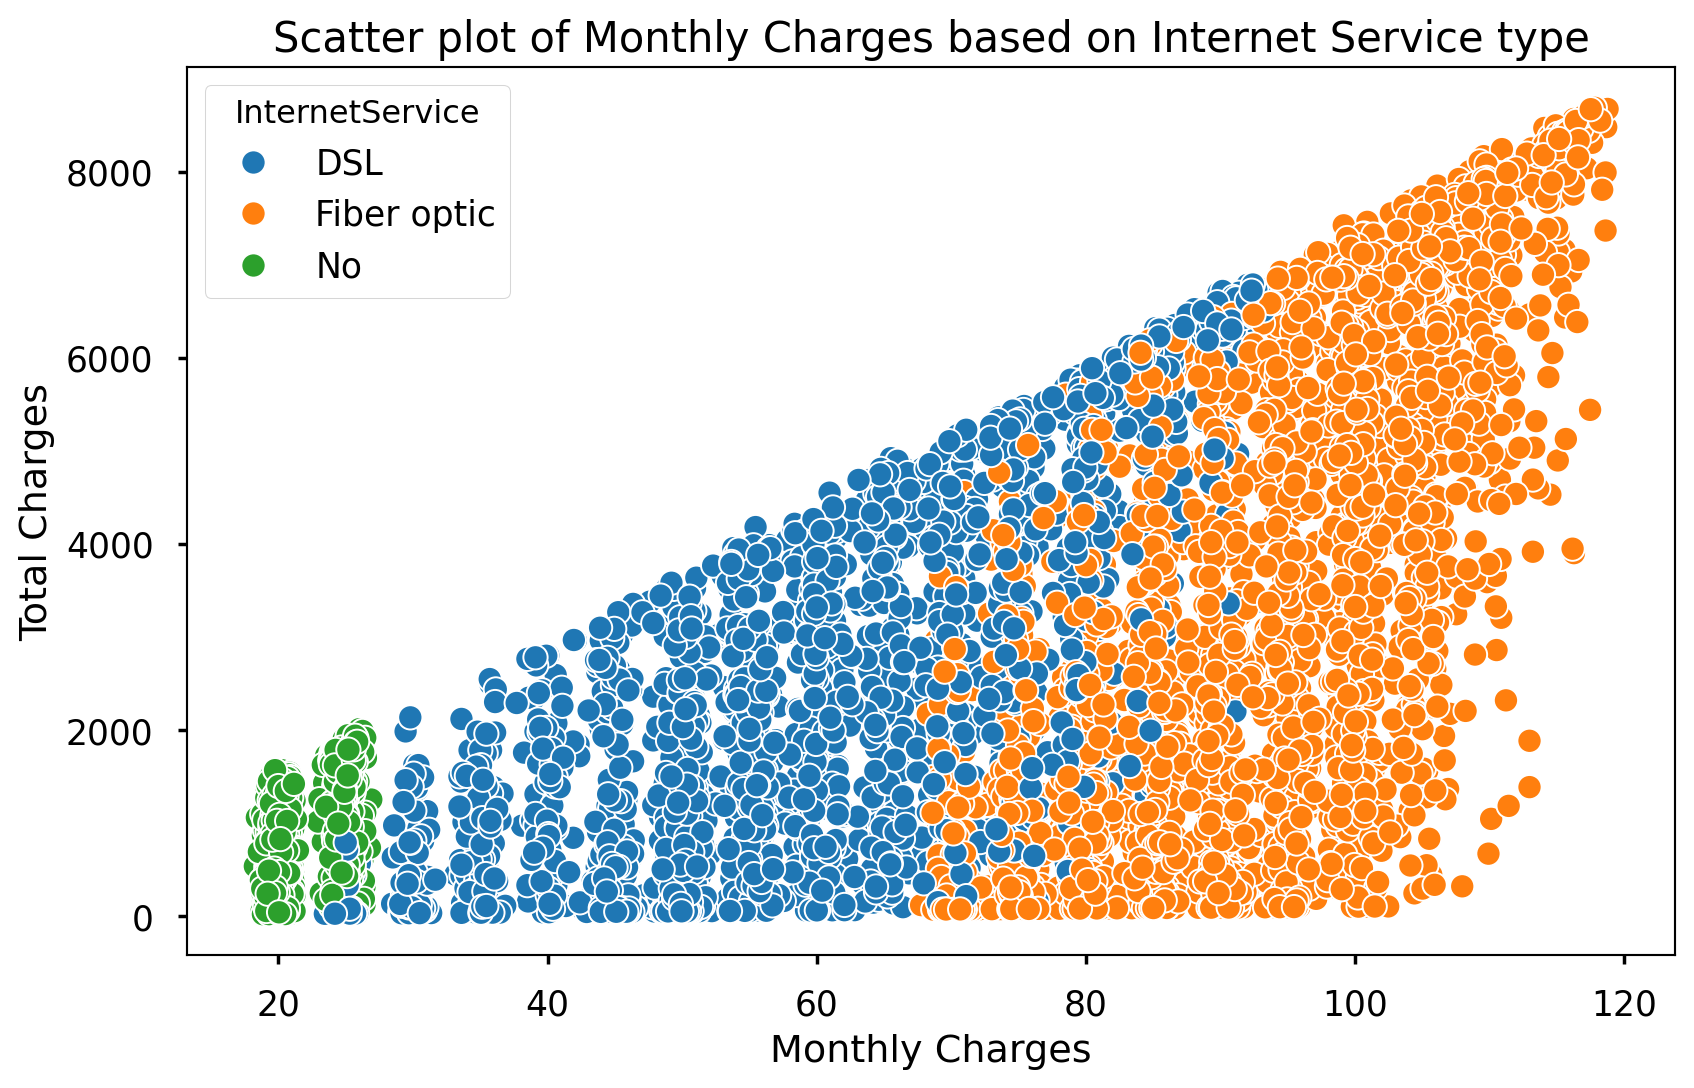

In [8]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='InternetService')
plt.title('Scatter plot of Monthly Charges based on Internet Service type')
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.show()

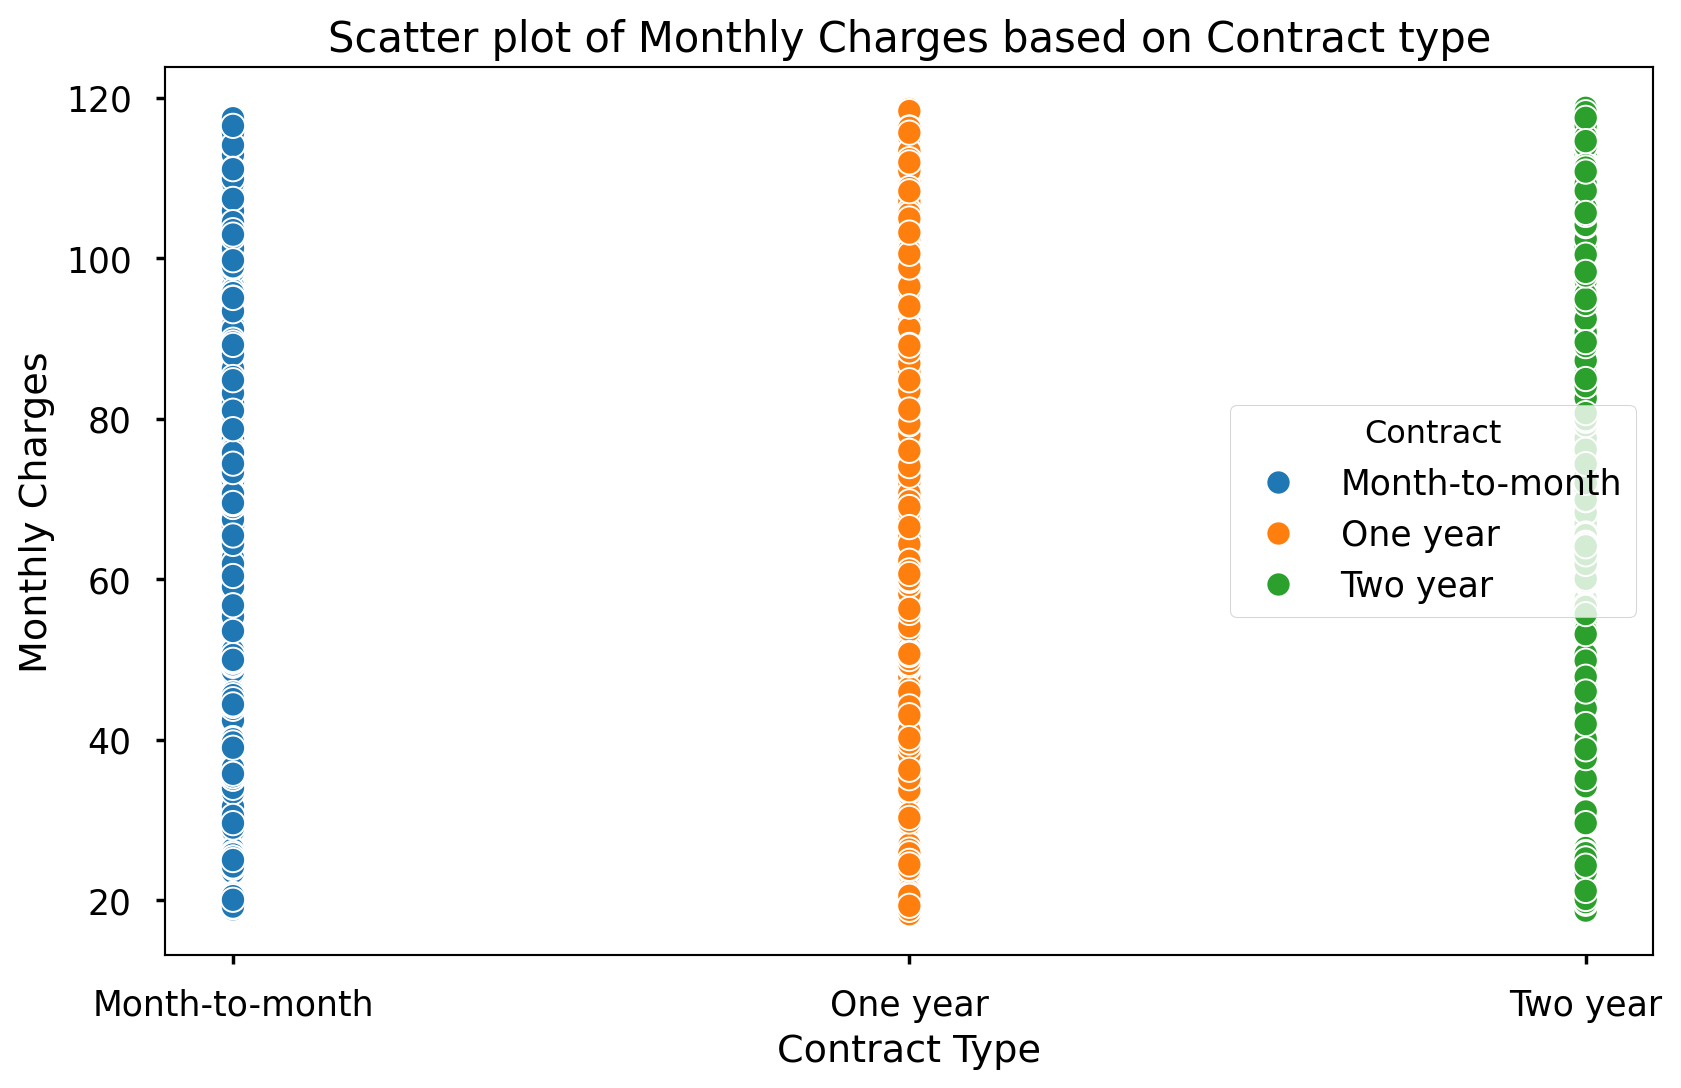

In [9]:
#| output: False
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Contract', y='MonthlyCharges', hue='Contract')
plt.title('Scatter plot of Monthly Charges based on Contract type')
plt.xlabel('Contract Type')
plt.ylabel('Monthly Charges')
plt.show()

In [10]:
def plot_churn_by_tenure(data, contract_type):
    # Create the bins
    bins = np.arange(0, data['tenure'].max() + 2, 2)  # +2 to include the last value
    data['tenure_bin'] = pd.cut(data['tenure'], bins=bins)
    
    # Calculate percentage of churned customers in each bin
    churn_by_tenure = (data.groupby('tenure_bin')['Churn']
                          .value_counts(normalize=True)
                          .unstack())
    
    plt.figure(figsize=(12, 8))
    churn_by_tenure['Yes'].multiply(100).plot(kind='bar')
    plt.title(f'Percentage of Churned Customers by Tenure Length\n{contract_type} Contracts')
    plt.xlabel('Tenure (months)')
    plt.ylabel('Churn Percentage')
    plt.axhline(y=50, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    # print(f"\nChurn percentage by tenure bins for {contract_type} contracts:")
    # print(churn_by_tenure['Yes'].multiply(100).round(1))

# Create three dataframes
monthly = df[df['Contract'] == 'Month-to-month']
one_year = df[df['Contract'] == 'One year']
two_year = df[df['Contract'] == 'Two year']

/var/folders/rz/zcgcqm0x1bl9cj8slq9l2s1c0000gn/T/ipykernel_14596/642956251.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/rz/zcgcqm0x1bl9cj8slq9l2s1c0000gn/T/ipykernel_14596/642956251.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



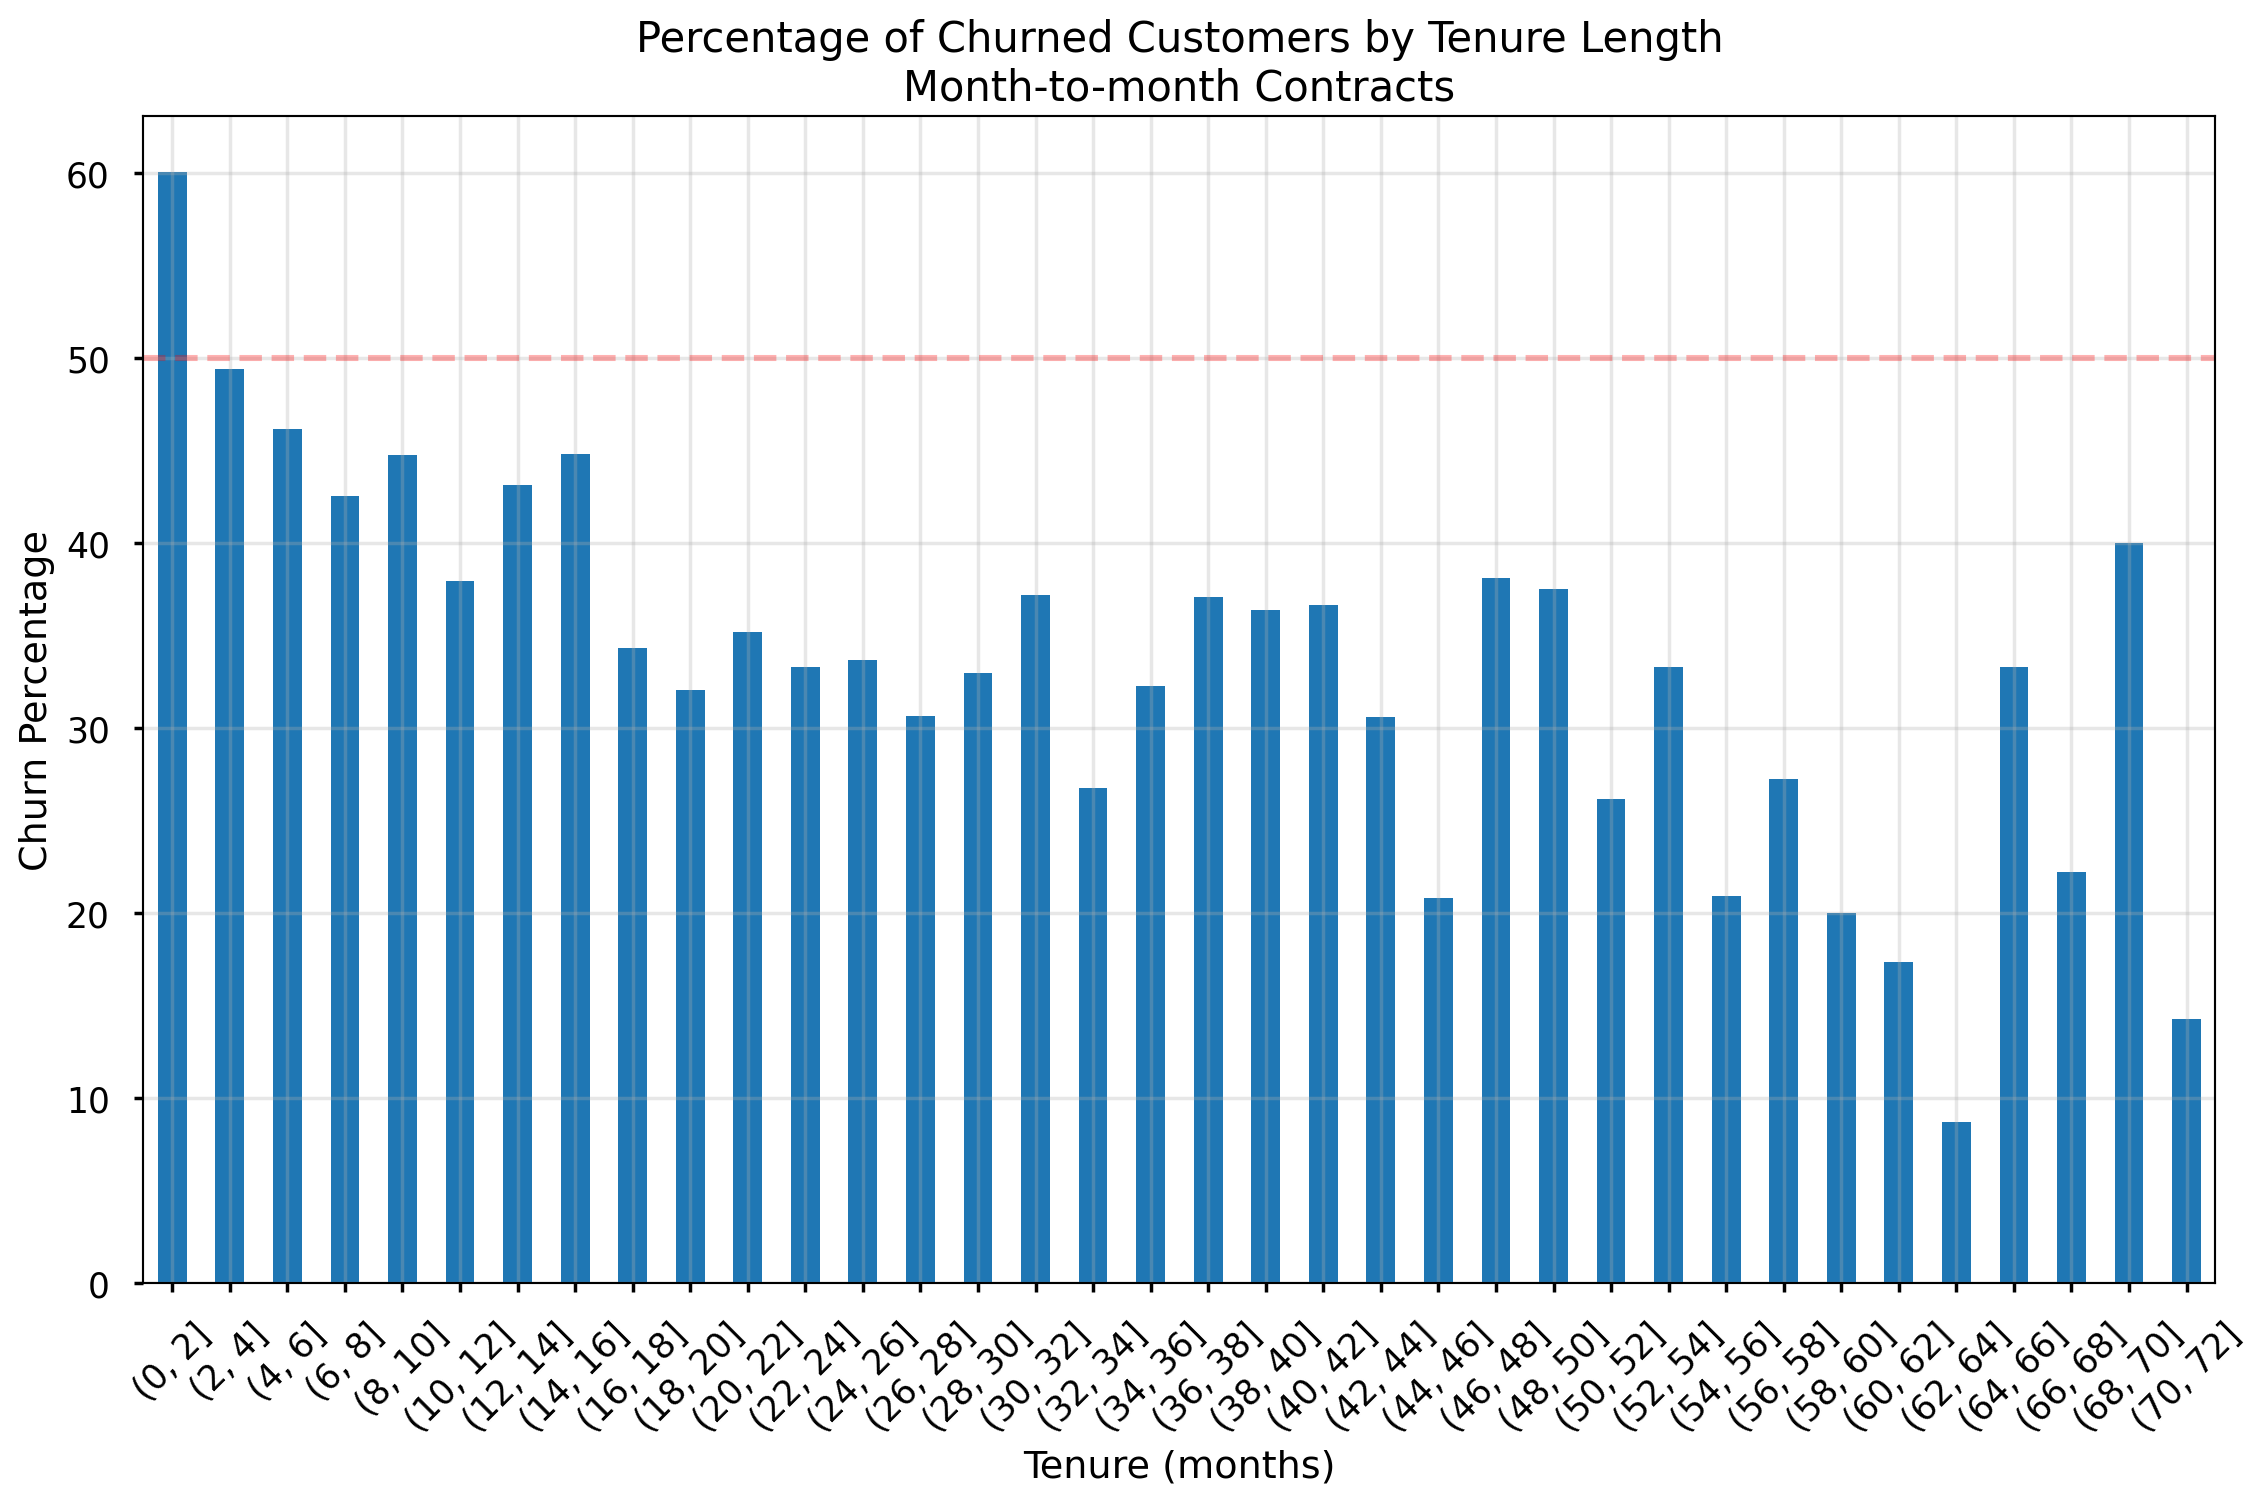

In [11]:
plot_churn_by_tenure(monthly, 'Month-to-month')

/var/folders/rz/zcgcqm0x1bl9cj8slq9l2s1c0000gn/T/ipykernel_14596/642956251.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/rz/zcgcqm0x1bl9cj8slq9l2s1c0000gn/T/ipykernel_14596/642956251.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



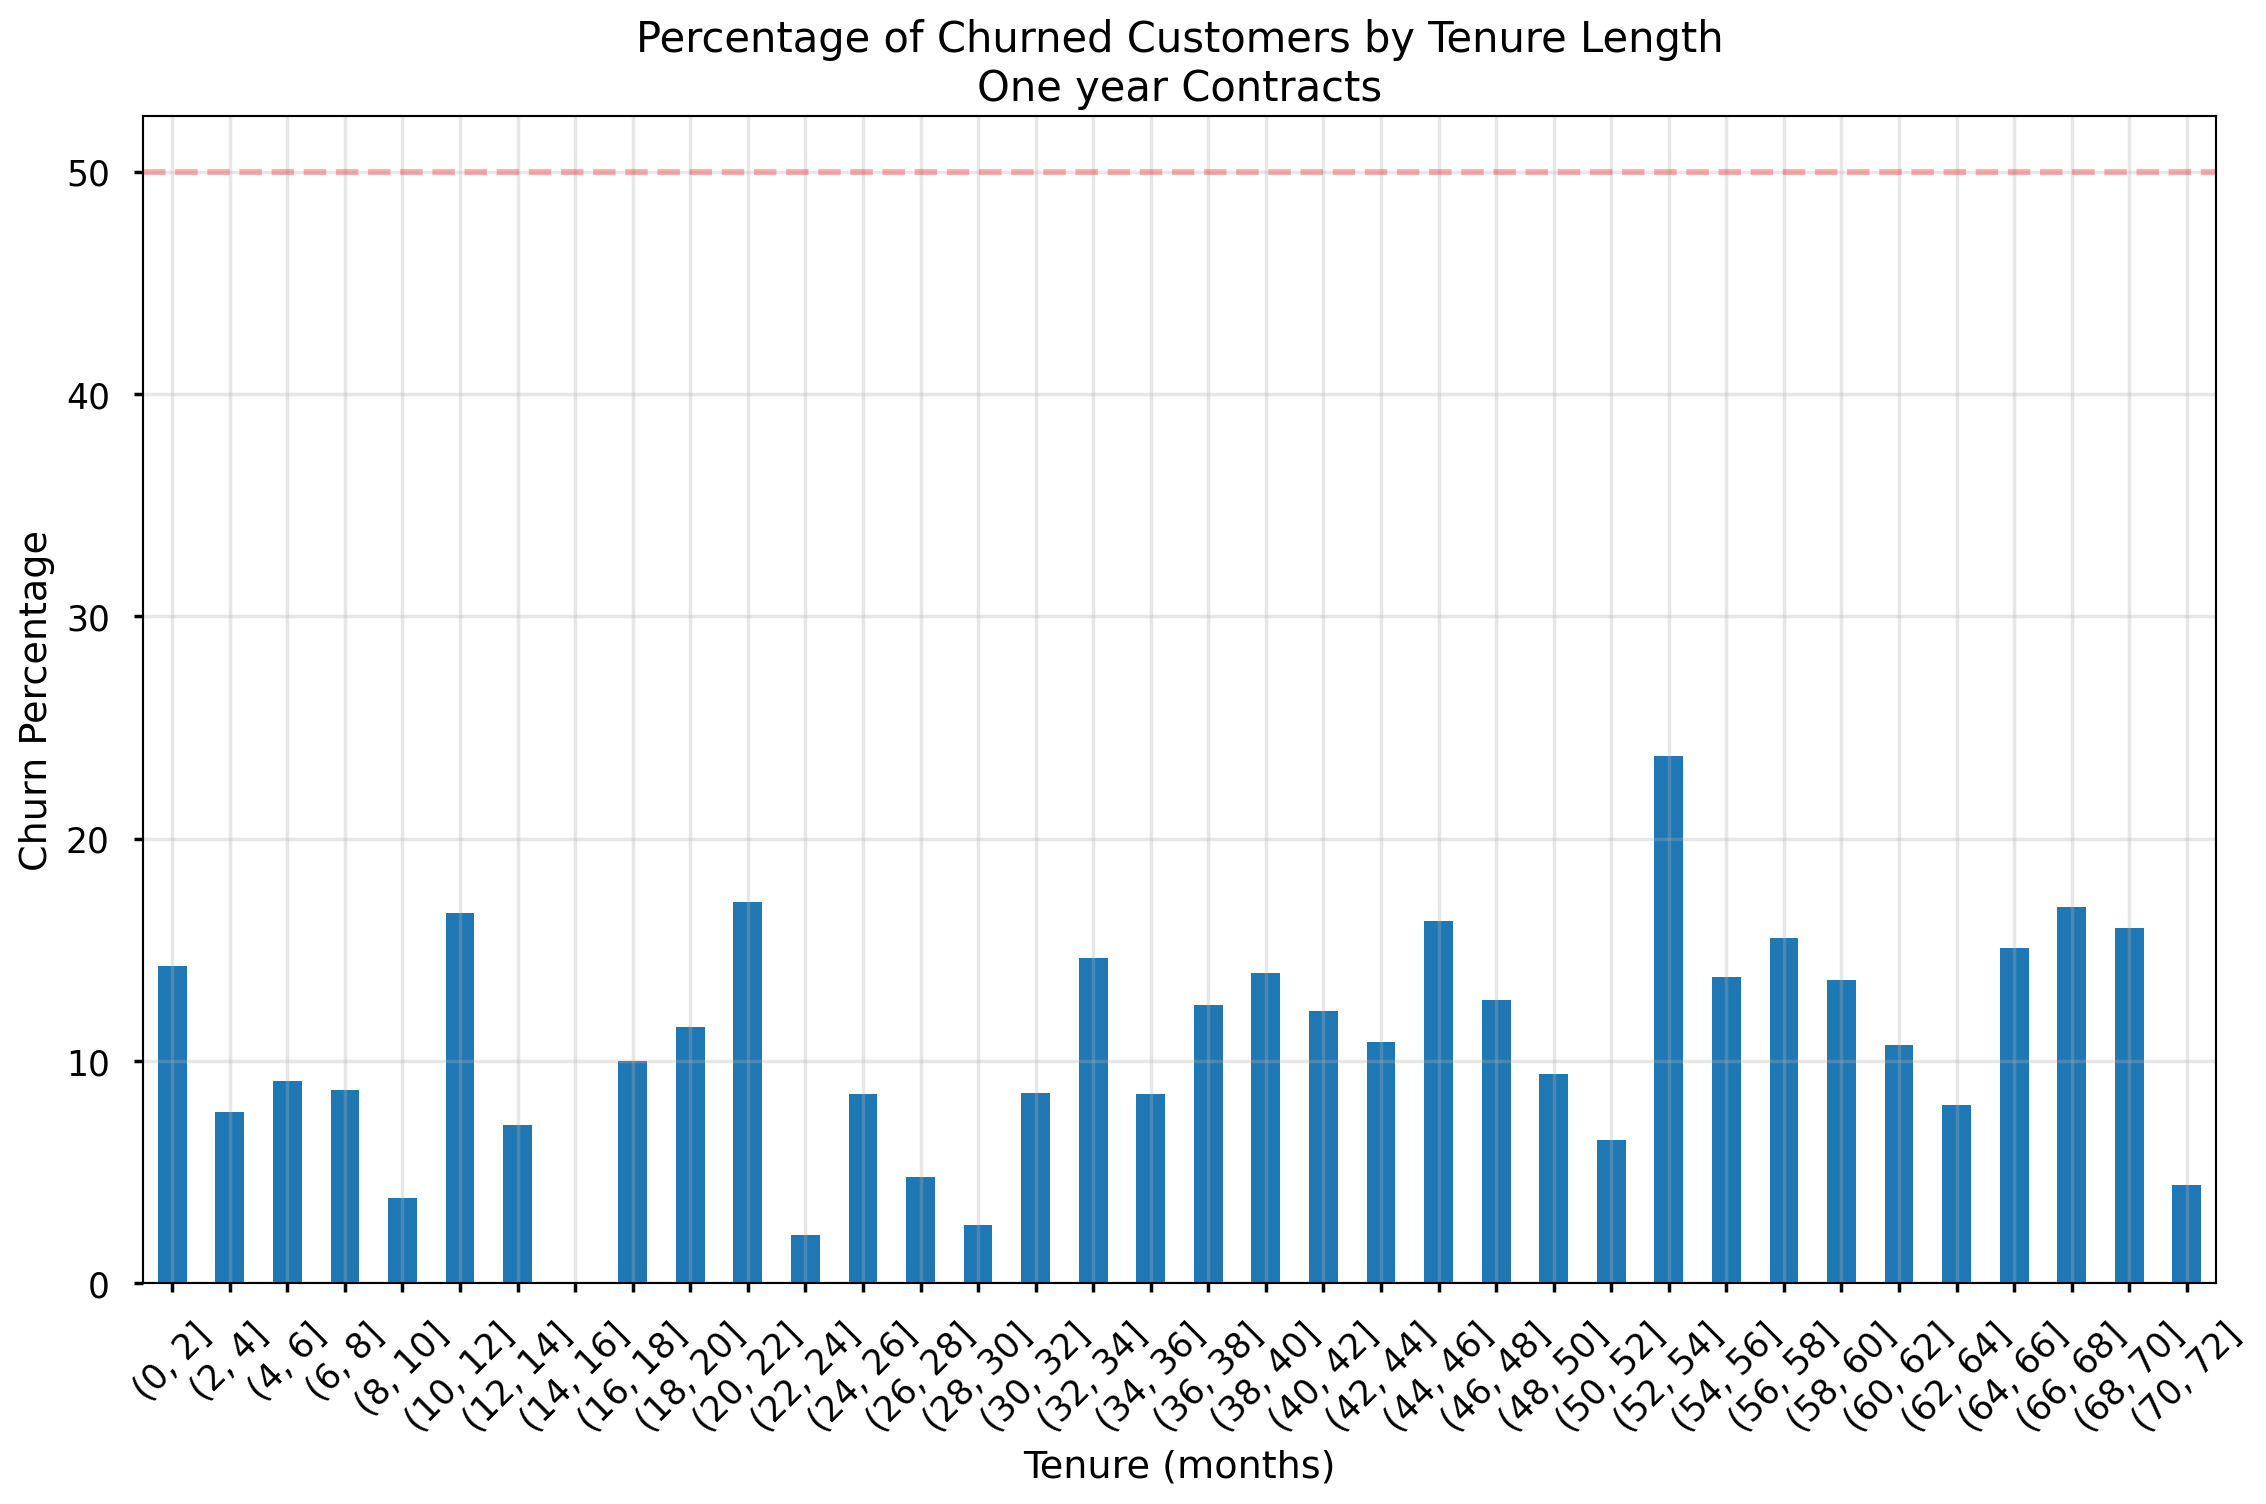

In [12]:
plot_churn_by_tenure(one_year, 'One year')

/var/folders/rz/zcgcqm0x1bl9cj8slq9l2s1c0000gn/T/ipykernel_14596/642956251.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/rz/zcgcqm0x1bl9cj8slq9l2s1c0000gn/T/ipykernel_14596/642956251.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



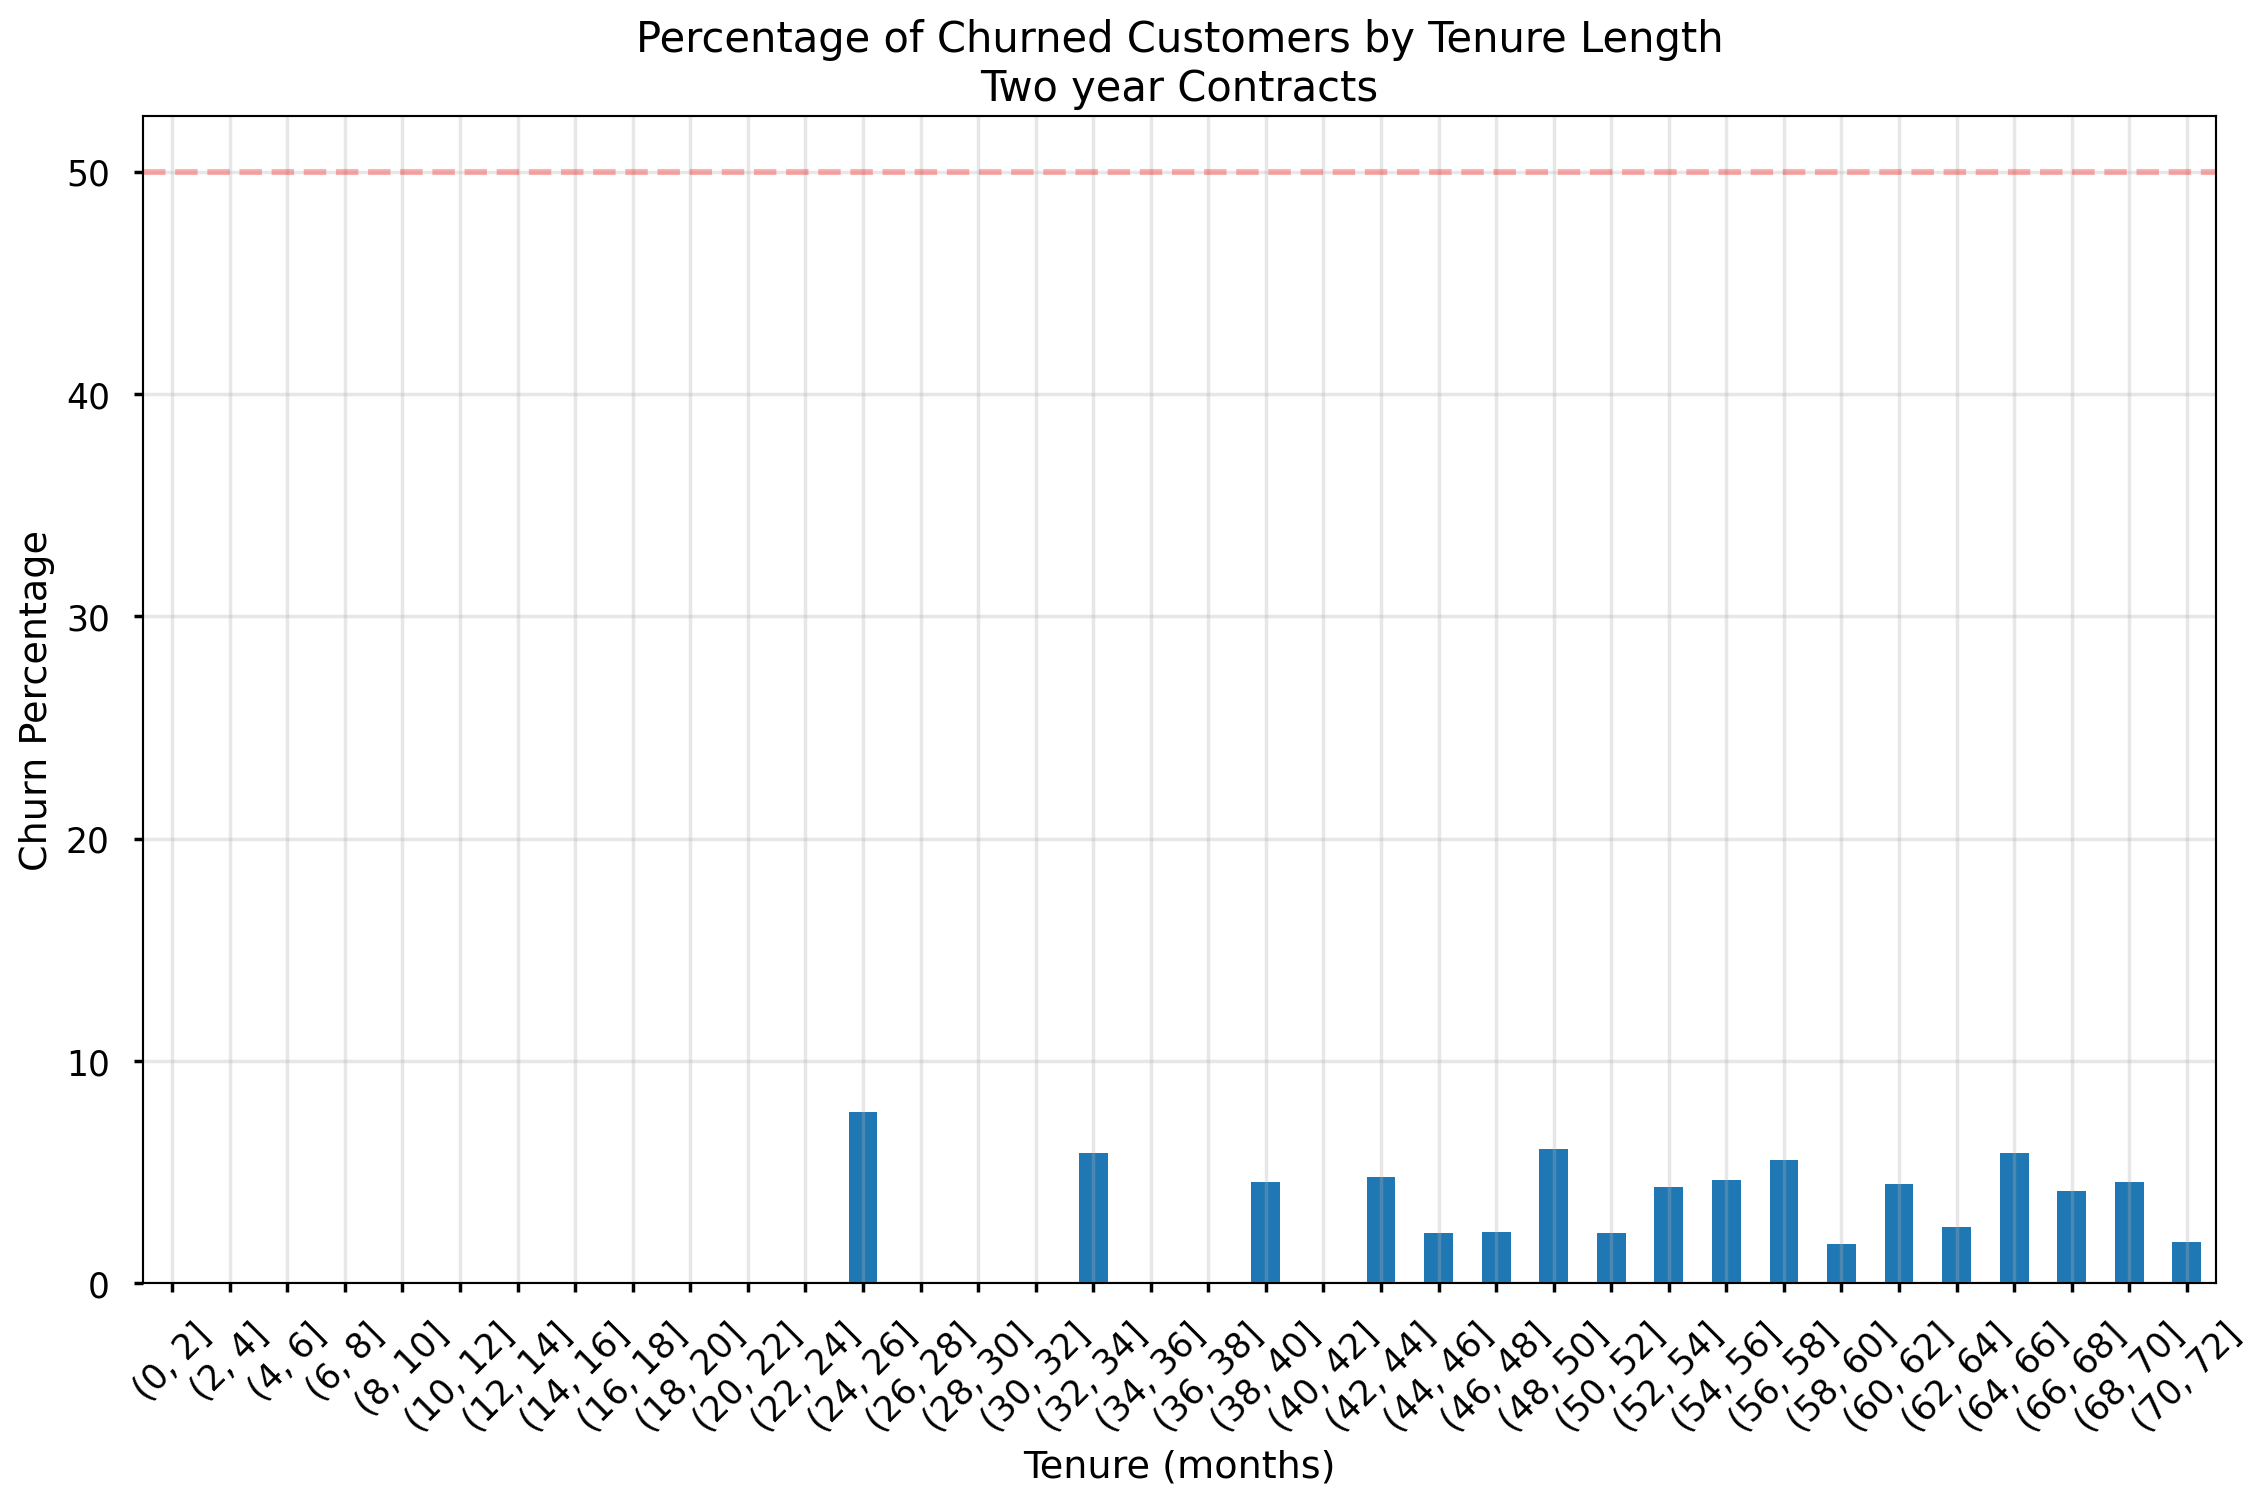

In [13]:
plot_churn_by_tenure(two_year, 'Two year')  